In [ ]:
import os

%run "/content/drive/MyDrive/inception_unet.ipynb"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from inception_unet import bulid_model


Shape before: (2, 2)
Shape after: (2, 2, 1)
[[[1]
  [2]]

 [[3]
  [4]]]


## Dice loss

In [ ]:
def dice_coeff(y_true,y_hat):
    smooth = 1e-15
    y_true = tf.keras.layers.Flatten()(y_true)
    y_hat = tf.keras.layers.Flatten()(y_hat)
    intersection = tf.reduce_sum(y_hat*y_true)
    return (2*intersection + smooth)/(tf.reduce_sum(y_true) + tf.reduce_sum(y_hat))



In [ ]:
def dice_loss(y_true,y_hat):
    return 1 - dice_coeff(y_true,y_hat)

## Read data


In [ ]:
path = "/content/drive/MyDrive/archive"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
epochs = 50

batch_size = 16
lr = 1e-3
W, H =256,256

In [ ]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    if len(images) < 3 or len(masks) < 3:
        raise ValueError("Insufficient data for splitting. Make sure you have at least three samples.")
    train_x, test_x, train_y, test_y = train_test_split(images[:3064], masks, test_size=split, random_state=42)
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=split, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(path)
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
#test_dataset = tf_dataset(test_x,test_y,batch = batch_size)



In [ ]:
test_dataset = tf_dataset(test_x,test_y,batch = batch_size)



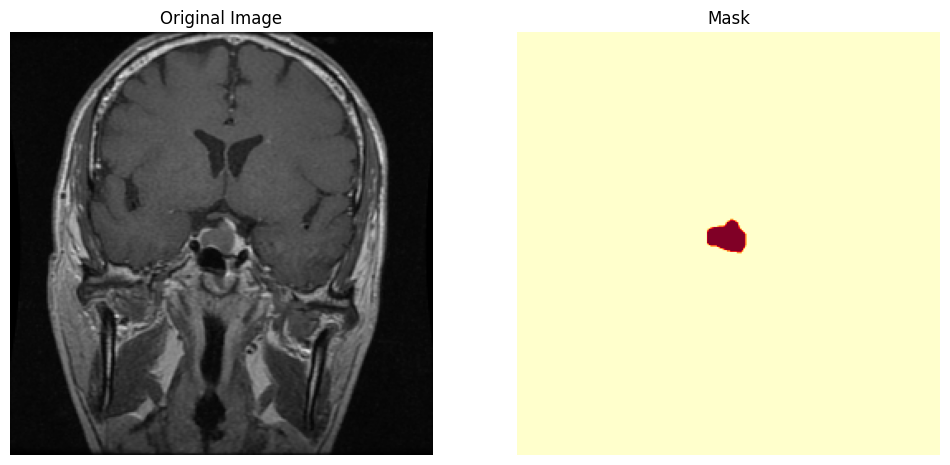

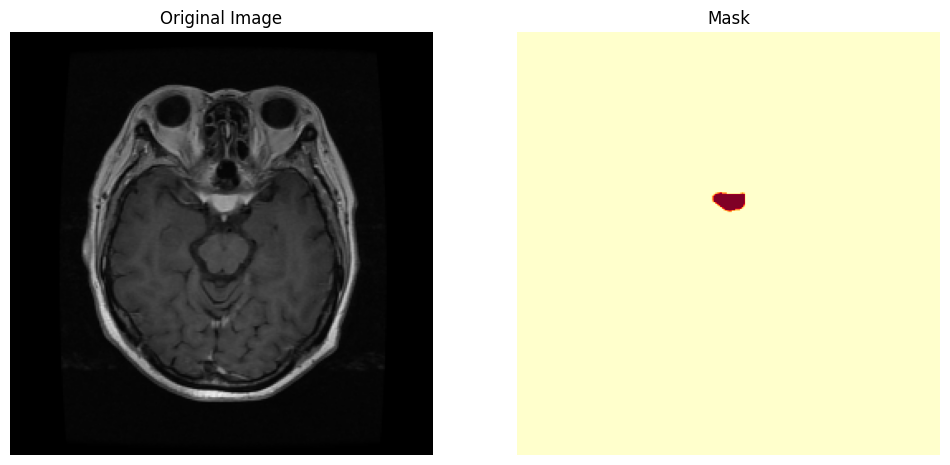

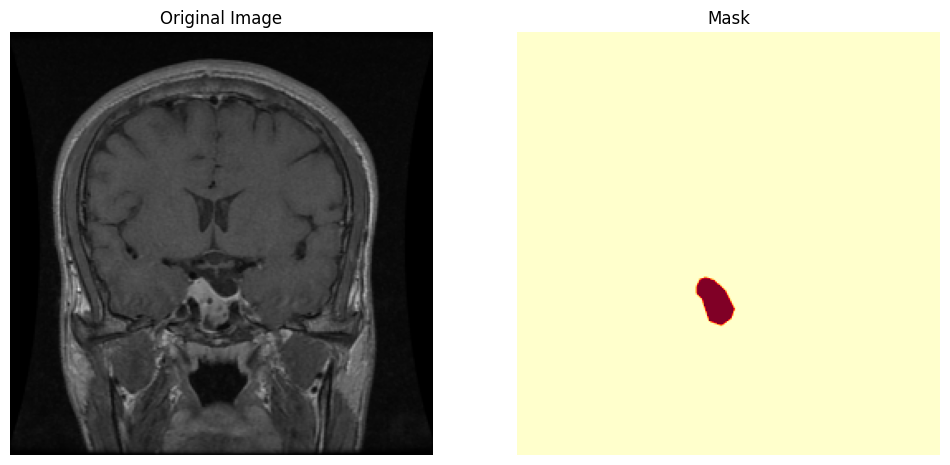

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# Create a tf.data.Dataset for visualization
visualization_dataset = tf_dataset(train_x[:3], train_y[:3], batch=3)

# Iterate through the dataset and visualize images and masks
for batch in visualization_dataset:
    images, masks = batch
    for i in range(images.shape[0]):
        plt.figure(figsize=(12, 6))

        # Visualize the original image
        plt.subplot(1, 2, 1)
        plt.imshow(images[i])
        plt.title("Original Image")
        plt.axis("off")

        # Visualize the corresponding mask
        plt.subplot(1, 2, 2)
        plt.imshow(np.squeeze(masks[i]), cmap='YlOrRd')  # Assuming masks are grayscale
        plt.title("Mask")
        plt.axis("off")

        plt.show()


## Model
**bold text**


In [ ]:
from tensorflow.keras.metrics import Recall, Precision,F1Score


model = bulid_model()
# Define your metrics
recall = Recall(name='recall')
precision = Precision(name='precision')

# Compile your model
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coeff, 'accuracy', recall, precision])

(None, 128, 128, 128) (None, 64, 64, 256) (None, 32, 32, 512) (None, 16, 16, 1024) (None, 16, 16, 2048) (None, 16, 16, 2048)
(None, 128, 128, 128)
(None, 256, 256, 1)


In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]


In [ ]:
model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/50
123/123 [==============================] - 197s 1s/step - loss: 0.8394 - dice_coeff: 0.1607 - accuracy: 0.8636 - recall: 0.5150 - precision: 0.0658 - val_loss: 0.9586 - val_dice_coeff: 0.0413 - val_accuracy: 0.2188 - val_recall: 1.0000 - val_precision: 0.0219 - lr: 0.0010
Epoch 2/50
123/123 [==============================] - 102s 829ms/step - loss: 0.7772 - dice_coeff: 0.2227 - accuracy: 0.9579 - recall: 0.3537 - precision: 0.1682 - val_loss: 0.9619 - val_dice_coeff: 0.0380 - val_accuracy: 0.1480 - val_recall: 1.0000 - val_precision: 0.0201 - lr: 0.0010
Epoch 3/50
123/123 [==============================] - 102s 828ms/step - loss: 0.7640 - dice_coeff: 0.2358 - accuracy: 0.9603 - recall: 0.3576 - precision: 0.1811 - val_loss: 0.9669 - val_dice_coeff: 0.0330 - val_accuracy: 0.0182 - val_recall: 0.9962 - val_precision: 0.0174 - lr: 0.0010
Epoch 4/50
123/123 [==============================] - 102s 827ms/step - loss: 0.7413 - dice_coeff: 0.2586 - accuracy: 0.9681 - recall: 0.3263 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-20ed7fb84a88>", line 1, in <cell line: 1>
    model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1813, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks.py", line 475, in on_train_batch_end
    self._call_batch_hook(ModeKeys.TRAIN, "end", batch, logs=logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks.py", line 322, in _call_batch_hook
    self._call_batch_end_hook(mode, batch, logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks.py", line 345, in _call_batch_end_hook
   

TypeError: ignored

In [ ]:
history = model.history.history
print(list(history.keys()))


['loss', 'dice_coeff', 'accuracy', 'recall', 'precision', 'val_loss', 'val_dice_coeff', 'val_accuracy', 'val_recall', 'val_precision', 'lr']


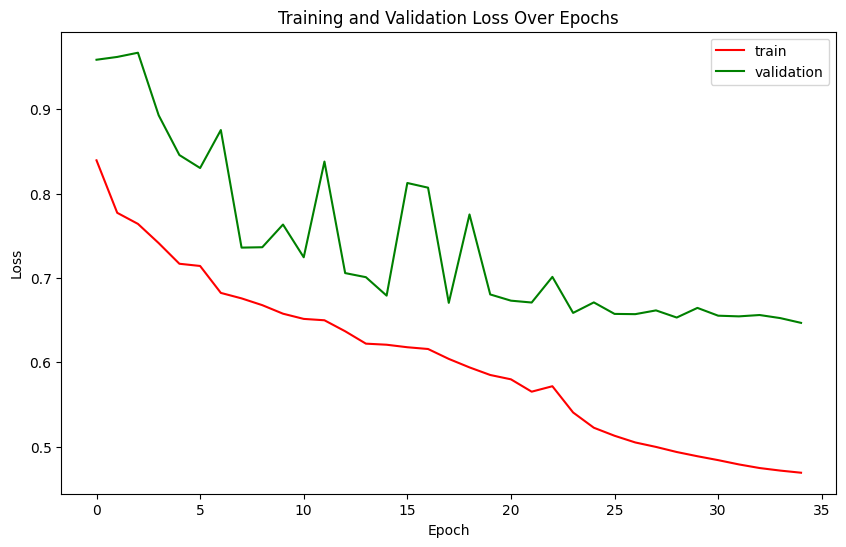

dict_keys(['loss', 'dice_coeff', 'accuracy', 'recall', 'precision', 'val_loss', 'val_dice_coeff', 'val_accuracy', 'val_recall', 'val_precision', 'lr'])


In [ ]:
history = model.history.history  # Access the history attribute

# Create a new figure and plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='train', color='r')
plt.plot(history['val_loss'], label='validation', color='g')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()
print(history.keys())

In [ ]:
result= model.evaluate(test_dataset)

print(f"Test Loss:{result[0]}")
print(f"Test dice coeff:{result[1]}")
print(f"Test Accuarcy:{result[2]*100} %")
print(f"Test Recall: {result[3]}")
print(f"Test Precision: {result[4]}")
f1_score = 2* ((result[4]* result[3])/(result[4]+result[3]))
print(f"Test F1Score: {f1_score}")


39/39 [==============================] - 234s 6s/step - loss: 0.6516 - dice_coeff: 0.3462 - accuracy: 0.9826 - recall: 0.2718 - precision: 0.5303
Test Loss:0.6515906453132629
Test dice coeff:0.34617677330970764
Test Accuarcy:98.25864434242249 %
Test Recall: 0.27183496952056885
Test Precision: 0.5302940607070923
Test F1Score: 0.3594246421634624


1/1 [==============================] - 2s 2s/step
[1]
1/1 [==============================] - 0s 104ms/step
[1]
1/1 [==============================] - 0s 189ms/step
[0]
1/1 [==============================] - 0s 57ms/step
[0]
1/1 [==============================] - 0s 132ms/step
[0]
1/1 [==============================] - 0s 142ms/step
[0]
1/1 [==============================] - 0s 68ms/step
[0]
1/1 [==============================] - 0s 156ms/step
[0]
1/1 [==============================] - 0s 71ms/step
[1]
1/1 [==============================] - 0s 49ms/step
[0]
1/1 [==============================] - 0s 59ms/step
[1]
1/1 [==============================] - 0s 32ms/step
[0]


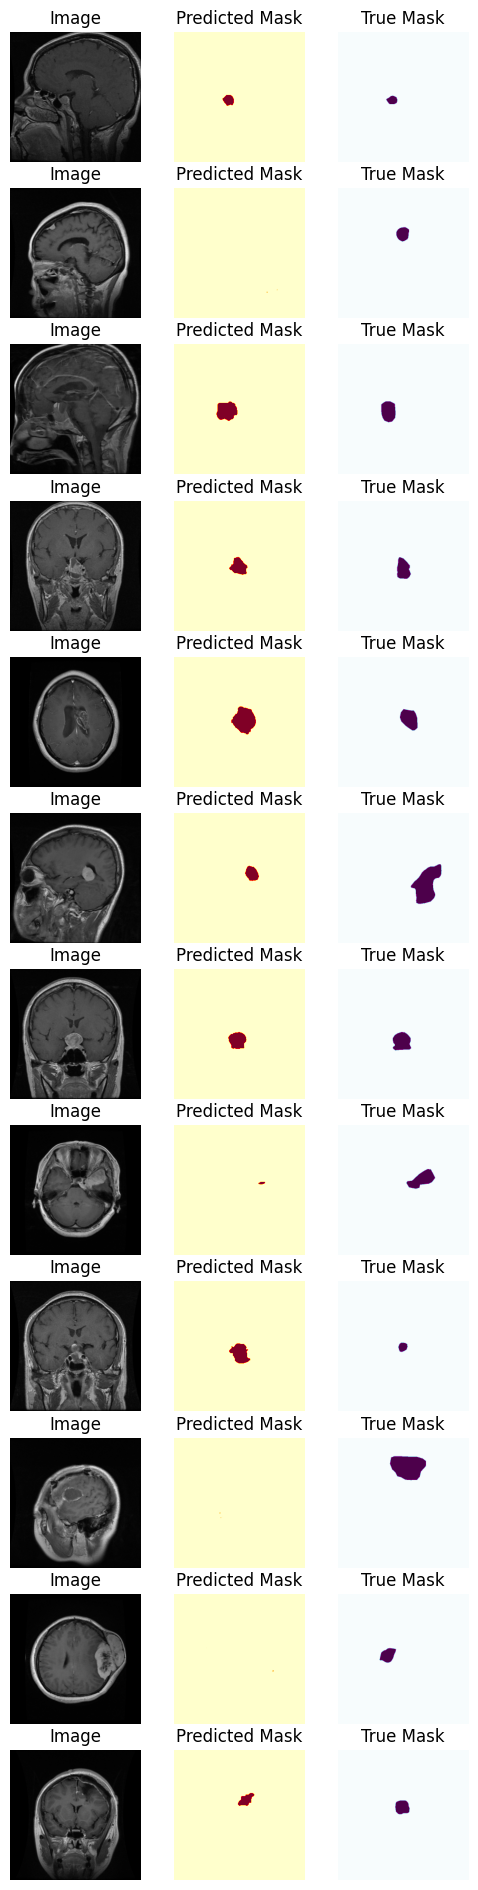

In [ ]:

num_samples = 12  # Specify the number of samples you want to visualize

visualization_dataset = test_dataset.take(num_samples)
plt.figure(figsize=(6, 2 * num_samples))
# Assuming valid_dataset provides tuples (image, mask)
for counter, (img_data, true_mask) in enumerate(visualization_dataset):
    # Expand dimensions if necessary (e.g., for grayscale images)
    # true_mask = np.expand_dims(true_mask, -1)

    # Make predictions
    prediction = model.predict(img_data)
    no_of_batch = np.random.randint(0, 2, 1)
    print(no_of_batch)

    # Plotting
    plt.subplot(num_samples, 3, 3 * counter + 1)
    plt.imshow(img_data[no_of_batch[0]])  # Accessing the first element in the batch
    plt.title("Image")
    plt.axis('off')

    plt.subplot(num_samples, 3, 3 * counter + 2)
    plt.imshow(prediction[no_of_batch[0]], cmap='YlOrRd')  # Change the colormap for predicted mask here
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(num_samples, 3, 3 * counter + 3)
    plt.imshow(true_mask[no_of_batch[0]], cmap='BuPu')  # Change the colormap for true mask here
    plt.title('True Mask')
    plt.axis('off')

plt.show()
